In [58]:
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(120220210)

# data

In [32]:
x = np.random.multivariate_normal([0, 0], # mean
                                  [[1, 0],[0, 1]], # covariance
                                  size = 300)
y = np.random.multivariate_normal([0, 0],
                                  [[1, 0.5],[0.5, 1]],
                                  size = 300)

In [ ]:
mi = np.concatenate((x, y), axis = 0)

plot toy datas

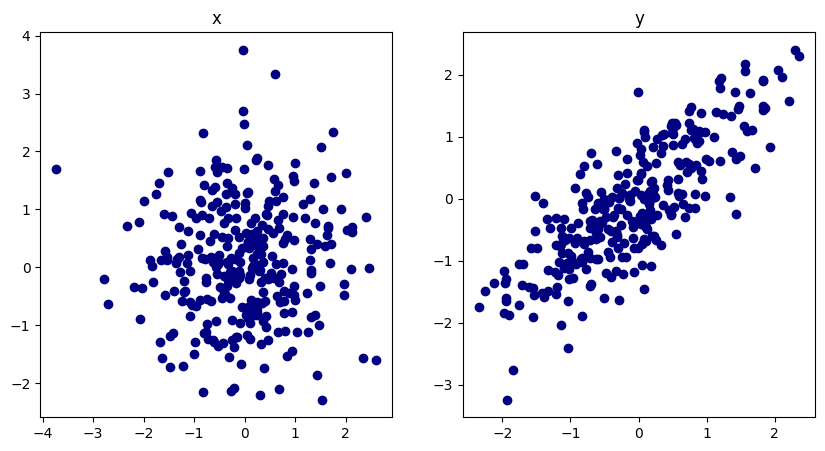

In [31]:
# scatter plot of x and y
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(x[:, 0], x[:, 1], color = 'navy')
ax[1].scatter(y[:, 0], y[:, 1], color = 'navy')
ax[0].title.set_text('x')
ax[1].title.set_text('y')
# fig.show()
fig.savefig('./images/toy_data_multigau.png')

In [34]:
def gen_x(num_samples):
    return np.sign(np.random.normal(0.,1.,[num_samples,1]))

def gen_y(x, var):
    return x + np.random.normal(0.,np.sqrt(var),[x.shape[0],1])
     

In [35]:

var = 0.2
num_samples = 1000000
x=gen_x(num_samples)
y=gen_y(x, var)
p_y_x=np.exp(-(y-x)**2/(2*var))
p_y_x_minus=np.exp(-(y+1)**2/(2*var))
p_y_x_plus=np.exp(-(y-1)**2/(2*var))
mi=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))
mi

0.6586568587377033

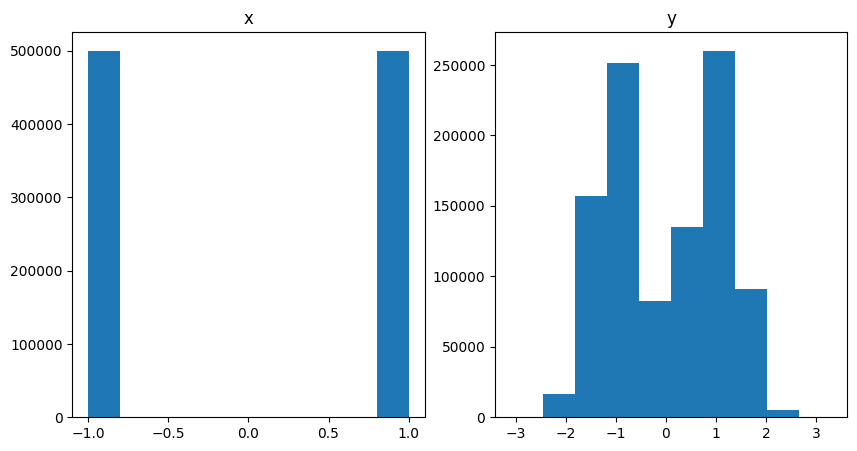

In [48]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(x)
ax[1].hist(y)
ax[0].title.set_text('x')
ax[1].title.set_text('y')
fig.savefig('./images/toy_data.png')

100%|██████████| 500/500 [00:03<00:00, 135.77it/s]


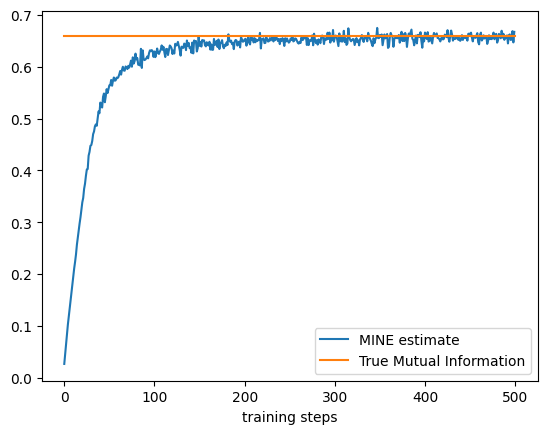

In [59]:
# https://github.com/seanie12/MINE/blob/master/mutual_information.ipynb 
# 의 구현을 참고하였다.
hidden_size=10
n_epoch = 500
data_size = 20000

class MINE(nn.Module):
    def __init__(self, hidden_size=10):
        super(MINE, self).__init__()
        self.layers= nn.Sequential(nn.Linear(2, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size,1))

    def forward(self, x, y):
        batch_size = x.size(0)
        tiled_x = torch.cat([x, x,], dim=0)
        idx = torch.randperm(batch_size)
        
        shuffled_y = y[idx]
        concat_y = torch.cat([y, shuffled_y], dim=0)
        
        inputs = torch.cat([tiled_x, concat_y], dim=1)
        logits = self.layers(inputs)

        pred_xy = logits[:batch_size]
        pred_x_y = logits[batch_size:]
        loss = -(torch.mean(pred_xy) 
               - torch.log(torch.mean(torch.exp(pred_x_y))))

        return loss

model = MINE(hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
plot_loss = []
all_mi = []
for epoch in tqdm(range(n_epoch)):
    x_sample=gen_x(data_size)
    y_sample=gen_y(x_sample, var)
    
    x_sample = torch.from_numpy(x_sample).float()
    y_sample = torch.from_numpy(y_sample).float()
    loss = model(x_sample, y_sample)
    
    model.zero_grad()
    loss.backward()
    optimizer.step()
   
    all_mi.append(-loss.item())


fig, ax = plt.subplots()
ax.plot(range(len(all_mi)), all_mi, label='MINE estimate')
ax.plot([0, len(all_mi)], [mi,mi], label='True Mutual Information')
ax.set_xlabel('training steps')
ax.legend(loc='best')
